# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

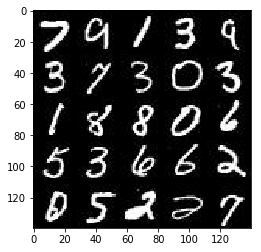

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

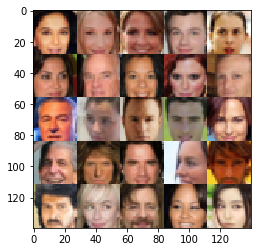

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    lr = tf.placeholder(tf.float32, name='lr')

    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28*28*3
        layer_1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        layer_1 = tf.maximum(alpha * layer_1, layer_1)
        # 14*14*64 now
        
        layer_2 = tf.layers.conv2d(layer_1, 128, 5, strides=1, padding='same')
        layer_2 = tf.layers.batch_normalization(layer_2, training=True)
        layer_2 = tf.maximum(alpha * layer_2, layer_2)
        # 14*14*128 now
        
        layer_3 = tf.layers.conv2d(layer_2, 256, 5, strides=2, padding='same')
        layer_3 = tf.layers.batch_normalization(layer_3, training=True)
        layer_3 = tf.maximum(alpha * layer_3, layer_3)
        # 7*7*256 now
        
        layer_4 = tf.layers.conv2d(layer_3, 512, 3, strides=1, padding='same')
        layer_4 = tf.layers.batch_normalization(layer_4, training=True)
        layer_4 = tf.maximum(alpha * layer_4, layer_4)
        # 7*7*512 now

        # Flatten it
        flat = tf.reshape(layer_4, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        layer_1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        layer_1 = tf.reshape(layer_1, (-1, 7, 7, 512))
        layer_1 = tf.layers.batch_normalization(layer_1, training=is_train)
        layer_1 = tf.maximum(alpha * layer_1, layer_1)
        # 7*7*512 now
        
        layer_2 = tf.layers.conv2d_transpose(layer_1, 256, 5, strides=1, padding='same')
        layer_2 = tf.layers.batch_normalization(layer_2, training=is_train)
        layer_2 = tf.maximum(alpha * layer_2, layer_2)
        # 7*7*256 now
        
        layer_3 = tf.layers.conv2d_transpose(layer_2, 128, 5, strides=2, padding='same')
        layer_3 = tf.layers.batch_normalization(layer_3, training=is_train)
        layer_3 = tf.maximum(alpha * layer_3, layer_3)
        # 14*14*128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(layer_3, out_channel_dim, 5, strides=2, padding='same')
        # 28*28*out_channel_dim now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # use smoothing by reducing labels to 0.9 as it prevents discriminator from being too strong
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=(tf.ones_like(d_model_real)*0.9)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3]) 
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    out_channel_dim = 3 if data_image_mode=="RGB" else 1
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Batch images for discriminator
                batch_images = batch_images * 2
                
                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               lr: learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, 
                                                input_real:batch_images,
                                                lr: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7359... Generator Loss: 23.6111
Epoch 1/2... Discriminator Loss: 0.9098... Generator Loss: 1.0910
Epoch 1/2... Discriminator Loss: 0.4557... Generator Loss: 3.5470
Epoch 1/2... Discriminator Loss: 2.7197... Generator Loss: 20.1973
Epoch 1/2... Discriminator Loss: 0.6371... Generator Loss: 2.3313
Epoch 1/2... Discriminator Loss: 1.1085... Generator Loss: 2.2610
Epoch 1/2... Discriminator Loss: 1.2422... Generator Loss: 0.8013
Epoch 1/2... Discriminator Loss: 1.1917... Generator Loss: 1.6283
Epoch 1/2... Discriminator Loss: 0.9127... Generator Loss: 2.8557
Epoch 1/2... Discriminator Loss: 0.6735... Generator Loss: 2.9420


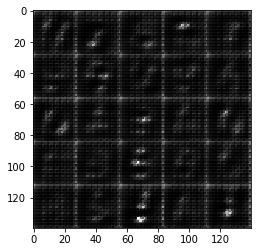

Epoch 1/2... Discriminator Loss: 0.6206... Generator Loss: 2.1777
Epoch 1/2... Discriminator Loss: 1.0059... Generator Loss: 3.4653
Epoch 1/2... Discriminator Loss: 2.7247... Generator Loss: 0.1907
Epoch 1/2... Discriminator Loss: 1.5367... Generator Loss: 0.4966
Epoch 1/2... Discriminator Loss: 1.8516... Generator Loss: 0.4027
Epoch 1/2... Discriminator Loss: 1.2498... Generator Loss: 0.7856
Epoch 1/2... Discriminator Loss: 0.9967... Generator Loss: 1.6854
Epoch 1/2... Discriminator Loss: 1.4943... Generator Loss: 2.8539
Epoch 1/2... Discriminator Loss: 1.9733... Generator Loss: 0.3790
Epoch 1/2... Discriminator Loss: 2.2151... Generator Loss: 0.2605


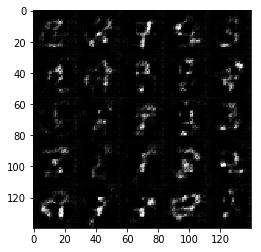

Epoch 1/2... Discriminator Loss: 0.9464... Generator Loss: 1.5103
Epoch 1/2... Discriminator Loss: 1.5559... Generator Loss: 0.4684
Epoch 1/2... Discriminator Loss: 1.8895... Generator Loss: 0.3247
Epoch 1/2... Discriminator Loss: 1.4484... Generator Loss: 2.8747
Epoch 1/2... Discriminator Loss: 1.5594... Generator Loss: 0.6176
Epoch 1/2... Discriminator Loss: 1.1265... Generator Loss: 1.0178
Epoch 1/2... Discriminator Loss: 0.9791... Generator Loss: 0.9518
Epoch 1/2... Discriminator Loss: 2.4283... Generator Loss: 4.3641
Epoch 1/2... Discriminator Loss: 1.1011... Generator Loss: 2.1903
Epoch 1/2... Discriminator Loss: 1.0888... Generator Loss: 1.9903


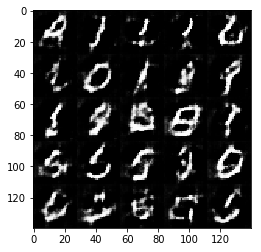

Epoch 1/2... Discriminator Loss: 1.0348... Generator Loss: 1.0677
Epoch 1/2... Discriminator Loss: 1.0112... Generator Loss: 1.1694
Epoch 1/2... Discriminator Loss: 1.3463... Generator Loss: 2.0993
Epoch 1/2... Discriminator Loss: 1.1232... Generator Loss: 2.4857
Epoch 1/2... Discriminator Loss: 1.1169... Generator Loss: 0.8754
Epoch 1/2... Discriminator Loss: 1.1465... Generator Loss: 1.8045
Epoch 1/2... Discriminator Loss: 1.1243... Generator Loss: 0.8368
Epoch 1/2... Discriminator Loss: 2.0842... Generator Loss: 3.8054
Epoch 1/2... Discriminator Loss: 1.1049... Generator Loss: 0.8874
Epoch 1/2... Discriminator Loss: 1.1832... Generator Loss: 0.8057


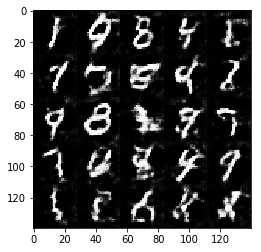

Epoch 1/2... Discriminator Loss: 1.2272... Generator Loss: 2.7864
Epoch 1/2... Discriminator Loss: 2.3526... Generator Loss: 0.2600
Epoch 1/2... Discriminator Loss: 1.1122... Generator Loss: 0.8046
Epoch 1/2... Discriminator Loss: 1.0624... Generator Loss: 2.2366
Epoch 1/2... Discriminator Loss: 0.9664... Generator Loss: 2.3614
Epoch 1/2... Discriminator Loss: 1.3827... Generator Loss: 2.4805
Epoch 1/2... Discriminator Loss: 1.0650... Generator Loss: 2.1173
Epoch 1/2... Discriminator Loss: 0.9926... Generator Loss: 1.7332
Epoch 1/2... Discriminator Loss: 1.0343... Generator Loss: 1.4484
Epoch 1/2... Discriminator Loss: 1.4310... Generator Loss: 0.5921


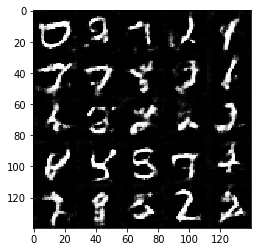

Epoch 1/2... Discriminator Loss: 1.2336... Generator Loss: 0.6513
Epoch 1/2... Discriminator Loss: 0.9263... Generator Loss: 1.4292
Epoch 1/2... Discriminator Loss: 1.4935... Generator Loss: 0.5924
Epoch 1/2... Discriminator Loss: 2.2030... Generator Loss: 0.2352
Epoch 1/2... Discriminator Loss: 1.1700... Generator Loss: 0.8024
Epoch 1/2... Discriminator Loss: 1.2917... Generator Loss: 0.7140
Epoch 1/2... Discriminator Loss: 1.1434... Generator Loss: 1.4865
Epoch 1/2... Discriminator Loss: 1.4790... Generator Loss: 0.5727
Epoch 1/2... Discriminator Loss: 1.2146... Generator Loss: 0.6775
Epoch 1/2... Discriminator Loss: 1.2341... Generator Loss: 0.6728


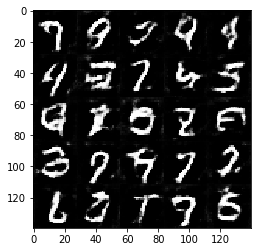

Epoch 1/2... Discriminator Loss: 1.4266... Generator Loss: 0.6062
Epoch 1/2... Discriminator Loss: 1.0041... Generator Loss: 1.2831
Epoch 1/2... Discriminator Loss: 1.4736... Generator Loss: 0.5651
Epoch 1/2... Discriminator Loss: 1.0337... Generator Loss: 0.8821
Epoch 1/2... Discriminator Loss: 1.4067... Generator Loss: 3.1362
Epoch 1/2... Discriminator Loss: 1.4695... Generator Loss: 0.6305
Epoch 1/2... Discriminator Loss: 0.7883... Generator Loss: 1.5443
Epoch 1/2... Discriminator Loss: 0.7938... Generator Loss: 1.7364
Epoch 1/2... Discriminator Loss: 0.7850... Generator Loss: 1.4271
Epoch 1/2... Discriminator Loss: 1.2488... Generator Loss: 0.7990


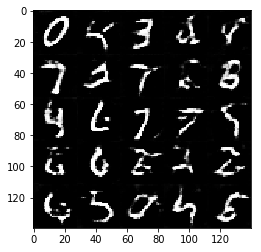

Epoch 1/2... Discriminator Loss: 1.3865... Generator Loss: 1.9520
Epoch 1/2... Discriminator Loss: 1.6744... Generator Loss: 0.4233
Epoch 1/2... Discriminator Loss: 1.2116... Generator Loss: 0.7405
Epoch 1/2... Discriminator Loss: 1.0495... Generator Loss: 1.4395
Epoch 1/2... Discriminator Loss: 1.0089... Generator Loss: 2.1971
Epoch 1/2... Discriminator Loss: 0.9104... Generator Loss: 1.4451
Epoch 1/2... Discriminator Loss: 1.6304... Generator Loss: 0.4417
Epoch 1/2... Discriminator Loss: 0.8438... Generator Loss: 1.2519
Epoch 1/2... Discriminator Loss: 1.6376... Generator Loss: 0.5309
Epoch 1/2... Discriminator Loss: 1.3744... Generator Loss: 2.4350


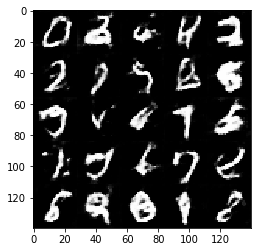

Epoch 1/2... Discriminator Loss: 0.8976... Generator Loss: 1.3001
Epoch 1/2... Discriminator Loss: 1.0729... Generator Loss: 1.0808
Epoch 1/2... Discriminator Loss: 0.9396... Generator Loss: 1.9426
Epoch 1/2... Discriminator Loss: 1.4716... Generator Loss: 0.5514
Epoch 1/2... Discriminator Loss: 1.3498... Generator Loss: 0.6925
Epoch 1/2... Discriminator Loss: 1.4188... Generator Loss: 0.5329
Epoch 1/2... Discriminator Loss: 0.9038... Generator Loss: 1.0797
Epoch 1/2... Discriminator Loss: 1.3146... Generator Loss: 2.1975
Epoch 1/2... Discriminator Loss: 0.9117... Generator Loss: 1.2656
Epoch 1/2... Discriminator Loss: 0.7677... Generator Loss: 1.3104


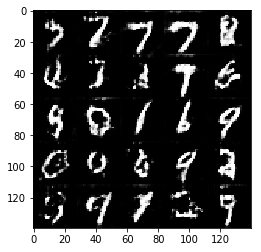

Epoch 1/2... Discriminator Loss: 0.8421... Generator Loss: 1.1104
Epoch 1/2... Discriminator Loss: 0.9952... Generator Loss: 0.9221
Epoch 1/2... Discriminator Loss: 2.0768... Generator Loss: 0.5801
Epoch 2/2... Discriminator Loss: 0.8842... Generator Loss: 1.6114
Epoch 2/2... Discriminator Loss: 3.8687... Generator Loss: 0.0866
Epoch 2/2... Discriminator Loss: 0.8427... Generator Loss: 1.2655
Epoch 2/2... Discriminator Loss: 1.2971... Generator Loss: 0.8171
Epoch 2/2... Discriminator Loss: 1.6037... Generator Loss: 0.4704
Epoch 2/2... Discriminator Loss: 0.8836... Generator Loss: 1.0612
Epoch 2/2... Discriminator Loss: 0.9309... Generator Loss: 1.0133


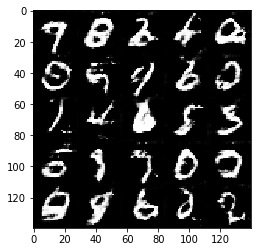

Epoch 2/2... Discriminator Loss: 0.6590... Generator Loss: 2.3155
Epoch 2/2... Discriminator Loss: 0.9211... Generator Loss: 1.2365
Epoch 2/2... Discriminator Loss: 1.0610... Generator Loss: 0.9358
Epoch 2/2... Discriminator Loss: 1.0656... Generator Loss: 0.9864
Epoch 2/2... Discriminator Loss: 2.6525... Generator Loss: 0.1755
Epoch 2/2... Discriminator Loss: 0.7461... Generator Loss: 1.4062
Epoch 2/2... Discriminator Loss: 1.3249... Generator Loss: 3.4439
Epoch 2/2... Discriminator Loss: 0.6888... Generator Loss: 1.4696
Epoch 2/2... Discriminator Loss: 1.3628... Generator Loss: 0.5535
Epoch 2/2... Discriminator Loss: 1.2569... Generator Loss: 0.7856


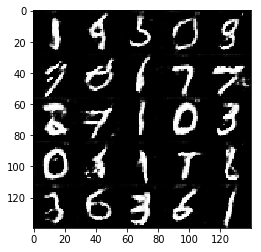

Epoch 2/2... Discriminator Loss: 0.9886... Generator Loss: 1.6768
Epoch 2/2... Discriminator Loss: 1.0808... Generator Loss: 0.9824
Epoch 2/2... Discriminator Loss: 1.6130... Generator Loss: 0.6003
Epoch 2/2... Discriminator Loss: 1.0754... Generator Loss: 0.8679
Epoch 2/2... Discriminator Loss: 1.4271... Generator Loss: 0.6402
Epoch 2/2... Discriminator Loss: 1.9734... Generator Loss: 3.7588
Epoch 2/2... Discriminator Loss: 0.9200... Generator Loss: 1.0490
Epoch 2/2... Discriminator Loss: 1.3097... Generator Loss: 2.8936
Epoch 2/2... Discriminator Loss: 2.1745... Generator Loss: 0.2692
Epoch 2/2... Discriminator Loss: 0.7328... Generator Loss: 2.1940


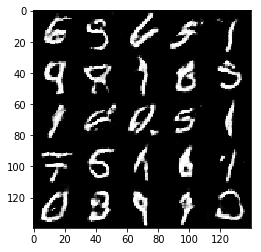

Epoch 2/2... Discriminator Loss: 0.7317... Generator Loss: 1.4422
Epoch 2/2... Discriminator Loss: 0.7213... Generator Loss: 1.3667
Epoch 2/2... Discriminator Loss: 0.7149... Generator Loss: 2.4137
Epoch 2/2... Discriminator Loss: 0.7651... Generator Loss: 2.0163
Epoch 2/2... Discriminator Loss: 0.5802... Generator Loss: 2.0044
Epoch 2/2... Discriminator Loss: 1.0680... Generator Loss: 0.9040
Epoch 2/2... Discriminator Loss: 1.8332... Generator Loss: 4.3563
Epoch 2/2... Discriminator Loss: 0.9997... Generator Loss: 2.6975
Epoch 2/2... Discriminator Loss: 1.6753... Generator Loss: 3.5941
Epoch 2/2... Discriminator Loss: 0.9162... Generator Loss: 1.3153


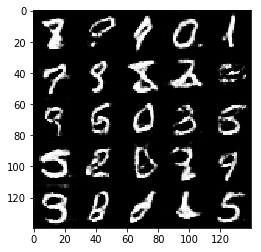

Epoch 2/2... Discriminator Loss: 1.5163... Generator Loss: 0.5647
Epoch 2/2... Discriminator Loss: 2.2535... Generator Loss: 0.2844
Epoch 2/2... Discriminator Loss: 0.7976... Generator Loss: 2.8118
Epoch 2/2... Discriminator Loss: 0.8052... Generator Loss: 2.0337
Epoch 2/2... Discriminator Loss: 0.8847... Generator Loss: 1.3937
Epoch 2/2... Discriminator Loss: 0.8655... Generator Loss: 1.2546
Epoch 2/2... Discriminator Loss: 0.7664... Generator Loss: 1.2846
Epoch 2/2... Discriminator Loss: 0.7585... Generator Loss: 1.3857
Epoch 2/2... Discriminator Loss: 0.8415... Generator Loss: 1.2015
Epoch 2/2... Discriminator Loss: 1.3639... Generator Loss: 2.7252


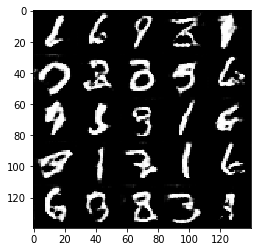

Epoch 2/2... Discriminator Loss: 1.2943... Generator Loss: 3.0787
Epoch 2/2... Discriminator Loss: 0.8182... Generator Loss: 1.7215
Epoch 2/2... Discriminator Loss: 0.8299... Generator Loss: 1.4414
Epoch 2/2... Discriminator Loss: 0.7993... Generator Loss: 1.3660
Epoch 2/2... Discriminator Loss: 1.7546... Generator Loss: 0.4305
Epoch 2/2... Discriminator Loss: 1.0595... Generator Loss: 4.0026
Epoch 2/2... Discriminator Loss: 0.9810... Generator Loss: 1.1534
Epoch 2/2... Discriminator Loss: 2.4906... Generator Loss: 0.2812
Epoch 2/2... Discriminator Loss: 1.1580... Generator Loss: 0.8097
Epoch 2/2... Discriminator Loss: 1.0879... Generator Loss: 0.9258


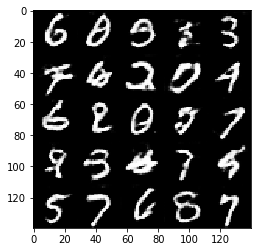

Epoch 2/2... Discriminator Loss: 1.4322... Generator Loss: 0.5688
Epoch 2/2... Discriminator Loss: 2.0540... Generator Loss: 0.3034
Epoch 2/2... Discriminator Loss: 2.5051... Generator Loss: 0.2572
Epoch 2/2... Discriminator Loss: 1.7113... Generator Loss: 0.4987
Epoch 2/2... Discriminator Loss: 0.7150... Generator Loss: 1.4052
Epoch 2/2... Discriminator Loss: 2.3845... Generator Loss: 0.2253
Epoch 2/2... Discriminator Loss: 0.6389... Generator Loss: 1.6544
Epoch 2/2... Discriminator Loss: 0.5091... Generator Loss: 2.2877
Epoch 2/2... Discriminator Loss: 0.5364... Generator Loss: 2.3322
Epoch 2/2... Discriminator Loss: 0.8070... Generator Loss: 1.5757


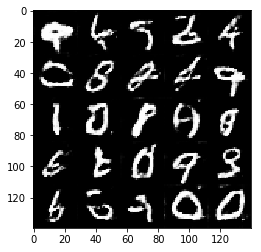

Epoch 2/2... Discriminator Loss: 1.0037... Generator Loss: 1.1102
Epoch 2/2... Discriminator Loss: 1.0007... Generator Loss: 0.9517
Epoch 2/2... Discriminator Loss: 0.7453... Generator Loss: 2.6243
Epoch 2/2... Discriminator Loss: 0.8259... Generator Loss: 2.8888
Epoch 2/2... Discriminator Loss: 1.9016... Generator Loss: 0.4225
Epoch 2/2... Discriminator Loss: 0.8303... Generator Loss: 1.2923
Epoch 2/2... Discriminator Loss: 1.6251... Generator Loss: 0.6461
Epoch 2/2... Discriminator Loss: 0.8055... Generator Loss: 2.1953
Epoch 2/2... Discriminator Loss: 1.3159... Generator Loss: 0.6853
Epoch 2/2... Discriminator Loss: 0.6412... Generator Loss: 1.7265


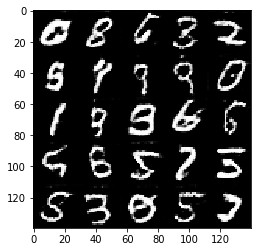

Epoch 2/2... Discriminator Loss: 1.3340... Generator Loss: 0.6558
Epoch 2/2... Discriminator Loss: 0.4826... Generator Loss: 2.5082
Epoch 2/2... Discriminator Loss: 0.6303... Generator Loss: 1.7666
Epoch 2/2... Discriminator Loss: 2.0814... Generator Loss: 4.3765
Epoch 2/2... Discriminator Loss: 0.7590... Generator Loss: 1.8538
Epoch 2/2... Discriminator Loss: 1.1331... Generator Loss: 3.0945
Epoch 2/2... Discriminator Loss: 0.9291... Generator Loss: 2.3669
Epoch 2/2... Discriminator Loss: 0.8133... Generator Loss: 1.3944
Epoch 2/2... Discriminator Loss: 1.8065... Generator Loss: 0.5005
Epoch 2/2... Discriminator Loss: 1.0506... Generator Loss: 0.9289


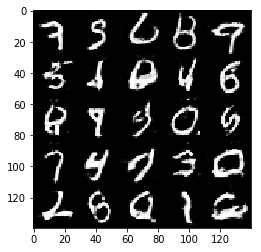

Epoch 2/2... Discriminator Loss: 1.1355... Generator Loss: 0.8843
Epoch 2/2... Discriminator Loss: 0.9680... Generator Loss: 1.2488
Epoch 2/2... Discriminator Loss: 0.6477... Generator Loss: 1.9231
Epoch 2/2... Discriminator Loss: 0.5911... Generator Loss: 1.8507
Epoch 2/2... Discriminator Loss: 2.6098... Generator Loss: 0.2537
Epoch 2/2... Discriminator Loss: 1.5521... Generator Loss: 0.6107
Epoch 2/2... Discriminator Loss: 1.0158... Generator Loss: 1.0042


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.5767... Generator Loss: 15.9384
Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 21.2020
Epoch 1/1... Discriminator Loss: 5.6385... Generator Loss: 0.0419
Epoch 1/1... Discriminator Loss: 1.6608... Generator Loss: 10.7728
Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 1.2057
Epoch 1/1... Discriminator Loss: 1.6077... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 1.0553
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 3.8818
Epoch 1/1... Discriminator Loss: 1.0583... Generator Loss: 1.7577


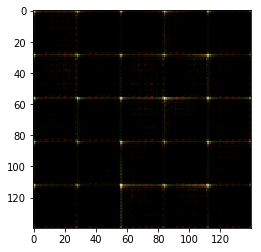

Epoch 1/1... Discriminator Loss: 2.1515... Generator Loss: 4.6637
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 1.1299
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 1.5608
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 2.9128
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 3.1507
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.5314
Epoch 1/1... Discriminator Loss: 1.9296... Generator Loss: 4.8033
Epoch 1/1... Discriminator Loss: 1.0712... Generator Loss: 1.0923
Epoch 1/1... Discriminator Loss: 0.9434... Generator Loss: 2.6887
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 0.7445


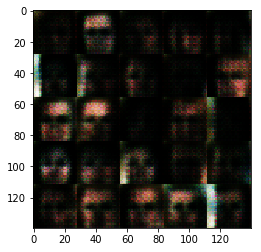

Epoch 1/1... Discriminator Loss: 1.5928... Generator Loss: 0.5882
Epoch 1/1... Discriminator Loss: 1.0253... Generator Loss: 0.9698
Epoch 1/1... Discriminator Loss: 0.6848... Generator Loss: 1.7417
Epoch 1/1... Discriminator Loss: 0.8726... Generator Loss: 1.1182
Epoch 1/1... Discriminator Loss: 3.6024... Generator Loss: 0.0685
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 0.7340... Generator Loss: 2.2130
Epoch 1/1... Discriminator Loss: 0.6375... Generator Loss: 2.9670
Epoch 1/1... Discriminator Loss: 1.0015... Generator Loss: 0.9334
Epoch 1/1... Discriminator Loss: 0.4812... Generator Loss: 2.4396


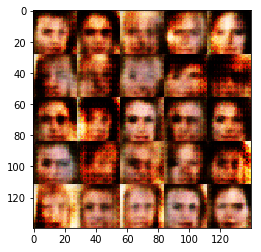

Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 5.0846
Epoch 1/1... Discriminator Loss: 1.2514... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 0.5705... Generator Loss: 2.1381
Epoch 1/1... Discriminator Loss: 1.1912... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 0.6146... Generator Loss: 4.3158
Epoch 1/1... Discriminator Loss: 0.5478... Generator Loss: 3.5196
Epoch 1/1... Discriminator Loss: 0.4611... Generator Loss: 3.5866
Epoch 1/1... Discriminator Loss: 0.6257... Generator Loss: 2.0462
Epoch 1/1... Discriminator Loss: 0.5882... Generator Loss: 2.5156
Epoch 1/1... Discriminator Loss: 0.7777... Generator Loss: 1.2623


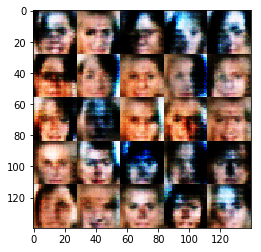

Epoch 1/1... Discriminator Loss: 0.4091... Generator Loss: 3.4975
Epoch 1/1... Discriminator Loss: 0.4393... Generator Loss: 4.1837
Epoch 1/1... Discriminator Loss: 0.3987... Generator Loss: 4.5750
Epoch 1/1... Discriminator Loss: 1.8344... Generator Loss: 0.3709
Epoch 1/1... Discriminator Loss: 0.5018... Generator Loss: 2.5677
Epoch 1/1... Discriminator Loss: 1.9622... Generator Loss: 0.3539
Epoch 1/1... Discriminator Loss: 0.5150... Generator Loss: 2.3573
Epoch 1/1... Discriminator Loss: 0.4505... Generator Loss: 2.9760
Epoch 1/1... Discriminator Loss: 3.4804... Generator Loss: 0.0764
Epoch 1/1... Discriminator Loss: 0.8127... Generator Loss: 1.6935


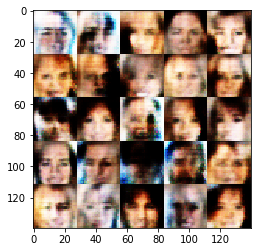

Epoch 1/1... Discriminator Loss: 0.4705... Generator Loss: 2.7315
Epoch 1/1... Discriminator Loss: 2.5712... Generator Loss: 0.1647
Epoch 1/1... Discriminator Loss: 1.4981... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 2.0528
Epoch 1/1... Discriminator Loss: 0.8060... Generator Loss: 1.3481
Epoch 1/1... Discriminator Loss: 0.8945... Generator Loss: 1.9206
Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 0.8268... Generator Loss: 2.6788
Epoch 1/1... Discriminator Loss: 1.1420... Generator Loss: 2.9694
Epoch 1/1... Discriminator Loss: 1.6441... Generator Loss: 0.5404


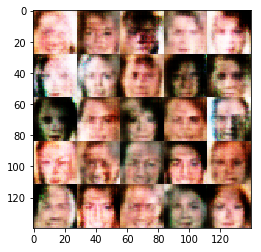

Epoch 1/1... Discriminator Loss: 0.5141... Generator Loss: 2.2293
Epoch 1/1... Discriminator Loss: 0.3911... Generator Loss: 3.8108
Epoch 1/1... Discriminator Loss: 0.9783... Generator Loss: 1.1771
Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.6166
Epoch 1/1... Discriminator Loss: 0.7581... Generator Loss: 1.4431
Epoch 1/1... Discriminator Loss: 0.9343... Generator Loss: 1.0952
Epoch 1/1... Discriminator Loss: 0.4303... Generator Loss: 3.1428
Epoch 1/1... Discriminator Loss: 0.4449... Generator Loss: 3.5834
Epoch 1/1... Discriminator Loss: 0.4419... Generator Loss: 2.7650


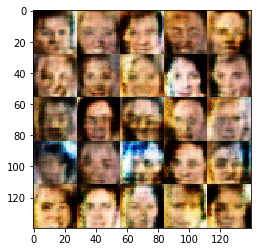

Epoch 1/1... Discriminator Loss: 0.3886... Generator Loss: 3.5645
Epoch 1/1... Discriminator Loss: 0.5030... Generator Loss: 4.4215
Epoch 1/1... Discriminator Loss: 1.6566... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 0.3791... Generator Loss: 4.2771
Epoch 1/1... Discriminator Loss: 0.7777... Generator Loss: 3.2626
Epoch 1/1... Discriminator Loss: 0.7305... Generator Loss: 1.5124
Epoch 1/1... Discriminator Loss: 0.6664... Generator Loss: 4.1127
Epoch 1/1... Discriminator Loss: 0.6098... Generator Loss: 1.9543
Epoch 1/1... Discriminator Loss: 0.6287... Generator Loss: 6.0113
Epoch 1/1... Discriminator Loss: 0.5742... Generator Loss: 1.9814


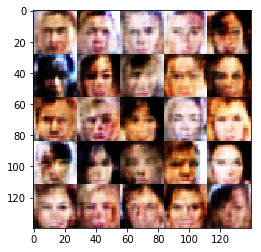

Epoch 1/1... Discriminator Loss: 0.8870... Generator Loss: 2.1554
Epoch 1/1... Discriminator Loss: 0.6463... Generator Loss: 1.6475
Epoch 1/1... Discriminator Loss: 0.4011... Generator Loss: 3.6686
Epoch 1/1... Discriminator Loss: 0.4537... Generator Loss: 2.4712
Epoch 1/1... Discriminator Loss: 0.7978... Generator Loss: 1.4465
Epoch 1/1... Discriminator Loss: 0.8698... Generator Loss: 1.0843
Epoch 1/1... Discriminator Loss: 0.5063... Generator Loss: 2.3324
Epoch 1/1... Discriminator Loss: 0.7690... Generator Loss: 1.3340
Epoch 1/1... Discriminator Loss: 0.9995... Generator Loss: 1.2578
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.6836


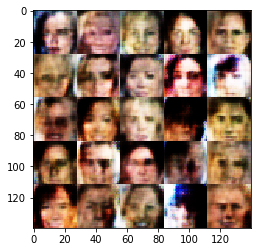

Epoch 1/1... Discriminator Loss: 0.5143... Generator Loss: 2.2391
Epoch 1/1... Discriminator Loss: 0.5009... Generator Loss: 2.6315
Epoch 1/1... Discriminator Loss: 0.3912... Generator Loss: 3.8960
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 2.5733
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 2.5708
Epoch 1/1... Discriminator Loss: 0.8813... Generator Loss: 1.9401
Epoch 1/1... Discriminator Loss: 1.0441... Generator Loss: 1.0416
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 3.5986
Epoch 1/1... Discriminator Loss: 0.6979... Generator Loss: 3.3193


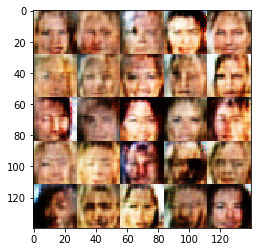

Epoch 1/1... Discriminator Loss: 0.5191... Generator Loss: 3.9443
Epoch 1/1... Discriminator Loss: 0.4608... Generator Loss: 2.5116
Epoch 1/1... Discriminator Loss: 0.4135... Generator Loss: 3.4361
Epoch 1/1... Discriminator Loss: 0.4557... Generator Loss: 3.5245
Epoch 1/1... Discriminator Loss: 3.5896... Generator Loss: 0.1190
Epoch 1/1... Discriminator Loss: 0.5354... Generator Loss: 4.0708
Epoch 1/1... Discriminator Loss: 2.8992... Generator Loss: 3.6874
Epoch 1/1... Discriminator Loss: 1.0476... Generator Loss: 0.9380
Epoch 1/1... Discriminator Loss: 0.5639... Generator Loss: 3.0004
Epoch 1/1... Discriminator Loss: 0.7265... Generator Loss: 1.7413


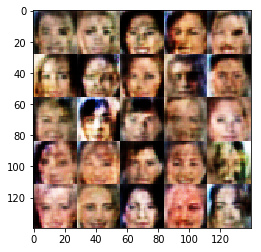

Epoch 1/1... Discriminator Loss: 0.8034... Generator Loss: 1.5390
Epoch 1/1... Discriminator Loss: 0.5537... Generator Loss: 1.9737
Epoch 1/1... Discriminator Loss: 0.5858... Generator Loss: 5.1188
Epoch 1/1... Discriminator Loss: 1.5488... Generator Loss: 0.5350
Epoch 1/1... Discriminator Loss: 1.6690... Generator Loss: 0.5491
Epoch 1/1... Discriminator Loss: 0.7285... Generator Loss: 2.5285
Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 4.5246
Epoch 1/1... Discriminator Loss: 0.4357... Generator Loss: 3.2329
Epoch 1/1... Discriminator Loss: 0.6514... Generator Loss: 1.5492
Epoch 1/1... Discriminator Loss: 0.5321... Generator Loss: 3.7431


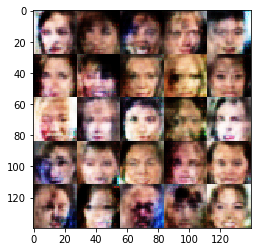

Epoch 1/1... Discriminator Loss: 0.4273... Generator Loss: 3.3368
Epoch 1/1... Discriminator Loss: 0.4145... Generator Loss: 3.5760
Epoch 1/1... Discriminator Loss: 0.4388... Generator Loss: 2.8212
Epoch 1/1... Discriminator Loss: 0.7077... Generator Loss: 1.4448
Epoch 1/1... Discriminator Loss: 3.3403... Generator Loss: 0.0941
Epoch 1/1... Discriminator Loss: 1.0326... Generator Loss: 1.0805
Epoch 1/1... Discriminator Loss: 0.7973... Generator Loss: 1.3622
Epoch 1/1... Discriminator Loss: 1.0378... Generator Loss: 1.2971
Epoch 1/1... Discriminator Loss: 0.8958... Generator Loss: 1.1449
Epoch 1/1... Discriminator Loss: 0.6318... Generator Loss: 2.0251


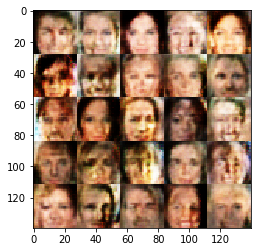

Epoch 1/1... Discriminator Loss: 0.4896... Generator Loss: 4.2136
Epoch 1/1... Discriminator Loss: 0.6049... Generator Loss: 4.6553
Epoch 1/1... Discriminator Loss: 0.4979... Generator Loss: 4.3823
Epoch 1/1... Discriminator Loss: 0.7226... Generator Loss: 4.8320
Epoch 1/1... Discriminator Loss: 1.1440... Generator Loss: 0.9201
Epoch 1/1... Discriminator Loss: 0.8690... Generator Loss: 1.6562
Epoch 1/1... Discriminator Loss: 0.8201... Generator Loss: 1.3631
Epoch 1/1... Discriminator Loss: 0.6377... Generator Loss: 2.1789
Epoch 1/1... Discriminator Loss: 0.7598... Generator Loss: 2.5346
Epoch 1/1... Discriminator Loss: 0.7006... Generator Loss: 2.6923


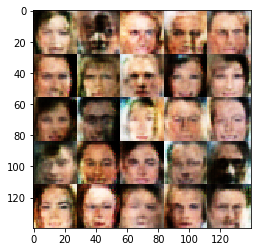

Epoch 1/1... Discriminator Loss: 0.8308... Generator Loss: 1.6368
Epoch 1/1... Discriminator Loss: 0.8092... Generator Loss: 1.5225
Epoch 1/1... Discriminator Loss: 1.3206... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 0.7975... Generator Loss: 2.6676
Epoch 1/1... Discriminator Loss: 0.6661... Generator Loss: 1.7969
Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 0.6777... Generator Loss: 1.6313
Epoch 1/1... Discriminator Loss: 0.7804... Generator Loss: 1.6522
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 0.9360... Generator Loss: 2.0940


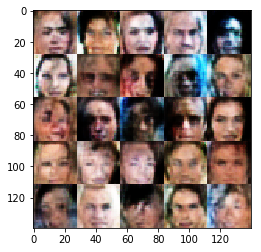

Epoch 1/1... Discriminator Loss: 0.4695... Generator Loss: 3.3516
Epoch 1/1... Discriminator Loss: 0.7231... Generator Loss: 1.3922
Epoch 1/1... Discriminator Loss: 1.7343... Generator Loss: 0.4571
Epoch 1/1... Discriminator Loss: 0.7331... Generator Loss: 1.6478
Epoch 1/1... Discriminator Loss: 0.9473... Generator Loss: 1.1366
Epoch 1/1... Discriminator Loss: 1.5771... Generator Loss: 0.6202
Epoch 1/1... Discriminator Loss: 0.6646... Generator Loss: 3.6736
Epoch 1/1... Discriminator Loss: 0.4201... Generator Loss: 4.4221
Epoch 1/1... Discriminator Loss: 0.7412... Generator Loss: 1.4852
Epoch 1/1... Discriminator Loss: 0.7067... Generator Loss: 3.5061


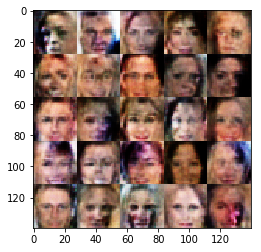

Epoch 1/1... Discriminator Loss: 0.6164... Generator Loss: 1.9614
Epoch 1/1... Discriminator Loss: 0.8662... Generator Loss: 1.1884
Epoch 1/1... Discriminator Loss: 1.4858... Generator Loss: 0.5955
Epoch 1/1... Discriminator Loss: 0.8684... Generator Loss: 2.8142
Epoch 1/1... Discriminator Loss: 0.7379... Generator Loss: 1.3858
Epoch 1/1... Discriminator Loss: 0.5705... Generator Loss: 2.1284
Epoch 1/1... Discriminator Loss: 0.4090... Generator Loss: 3.4535
Epoch 1/1... Discriminator Loss: 2.3652... Generator Loss: 4.4394
Epoch 1/1... Discriminator Loss: 0.6685... Generator Loss: 1.6836
Epoch 1/1... Discriminator Loss: 0.7761... Generator Loss: 1.3394


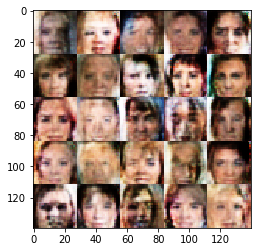

Epoch 1/1... Discriminator Loss: 0.7583... Generator Loss: 1.7468
Epoch 1/1... Discriminator Loss: 0.5818... Generator Loss: 1.8505
Epoch 1/1... Discriminator Loss: 0.5339... Generator Loss: 2.1093
Epoch 1/1... Discriminator Loss: 0.3979... Generator Loss: 3.5838
Epoch 1/1... Discriminator Loss: 0.9790... Generator Loss: 2.4308
Epoch 1/1... Discriminator Loss: 0.6371... Generator Loss: 2.4298
Epoch 1/1... Discriminator Loss: 0.7916... Generator Loss: 2.7733
Epoch 1/1... Discriminator Loss: 0.7857... Generator Loss: 1.3808
Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 0.9377
Epoch 1/1... Discriminator Loss: 0.7292... Generator Loss: 3.1710


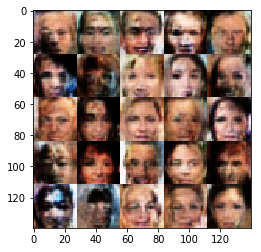

Epoch 1/1... Discriminator Loss: 0.4562... Generator Loss: 4.7531
Epoch 1/1... Discriminator Loss: 0.4212... Generator Loss: 3.2582
Epoch 1/1... Discriminator Loss: 0.5534... Generator Loss: 2.0834
Epoch 1/1... Discriminator Loss: 0.4228... Generator Loss: 4.5733
Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 6.4214
Epoch 1/1... Discriminator Loss: 0.5131... Generator Loss: 2.9618
Epoch 1/1... Discriminator Loss: 2.6225... Generator Loss: 5.9483
Epoch 1/1... Discriminator Loss: 1.0317... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 0.6006... Generator Loss: 4.9651
Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 3.8688


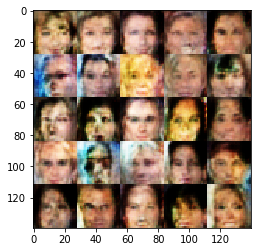

Epoch 1/1... Discriminator Loss: 0.6634... Generator Loss: 1.6544
Epoch 1/1... Discriminator Loss: 0.9632... Generator Loss: 0.9882
Epoch 1/1... Discriminator Loss: 0.8124... Generator Loss: 1.5407
Epoch 1/1... Discriminator Loss: 0.7035... Generator Loss: 2.2301
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 0.6351... Generator Loss: 3.2102
Epoch 1/1... Discriminator Loss: 0.3941... Generator Loss: 4.1413
Epoch 1/1... Discriminator Loss: 0.4849... Generator Loss: 3.2572
Epoch 1/1... Discriminator Loss: 0.6406... Generator Loss: 3.5576
Epoch 1/1... Discriminator Loss: 0.4595... Generator Loss: 4.4978


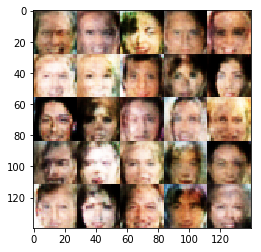

Epoch 1/1... Discriminator Loss: 0.9950... Generator Loss: 1.3557
Epoch 1/1... Discriminator Loss: 0.4073... Generator Loss: 3.8320
Epoch 1/1... Discriminator Loss: 0.3911... Generator Loss: 4.2497
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 1.1384
Epoch 1/1... Discriminator Loss: 0.8930... Generator Loss: 2.1427
Epoch 1/1... Discriminator Loss: 0.8943... Generator Loss: 2.1380
Epoch 1/1... Discriminator Loss: 0.6382... Generator Loss: 2.0150
Epoch 1/1... Discriminator Loss: 0.6490... Generator Loss: 1.6652
Epoch 1/1... Discriminator Loss: 0.7560... Generator Loss: 2.1518
Epoch 1/1... Discriminator Loss: 0.6371... Generator Loss: 1.8584


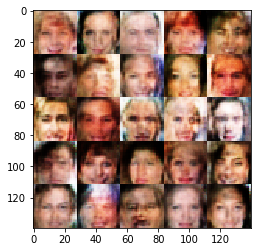

Epoch 1/1... Discriminator Loss: 0.5878... Generator Loss: 1.9916
Epoch 1/1... Discriminator Loss: 0.4417... Generator Loss: 3.8276
Epoch 1/1... Discriminator Loss: 1.9305... Generator Loss: 6.4514
Epoch 1/1... Discriminator Loss: 0.8502... Generator Loss: 1.2605
Epoch 1/1... Discriminator Loss: 0.7724... Generator Loss: 1.4919
Epoch 1/1... Discriminator Loss: 0.4725... Generator Loss: 2.7468
Epoch 1/1... Discriminator Loss: 0.5069... Generator Loss: 4.7088
Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 5.4904
Epoch 1/1... Discriminator Loss: 0.6695... Generator Loss: 1.7747
Epoch 1/1... Discriminator Loss: 0.8152... Generator Loss: 5.0899


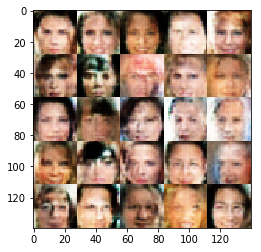

Epoch 1/1... Discriminator Loss: 0.6779... Generator Loss: 5.5548
Epoch 1/1... Discriminator Loss: 0.5590... Generator Loss: 2.1287
Epoch 1/1... Discriminator Loss: 0.8925... Generator Loss: 1.2955
Epoch 1/1... Discriminator Loss: 0.5606... Generator Loss: 2.1076
Epoch 1/1... Discriminator Loss: 1.2113... Generator Loss: 1.0390
Epoch 1/1... Discriminator Loss: 0.6322... Generator Loss: 1.7476
Epoch 1/1... Discriminator Loss: 0.6143... Generator Loss: 1.9807
Epoch 1/1... Discriminator Loss: 0.4432... Generator Loss: 3.0901
Epoch 1/1... Discriminator Loss: 0.8427... Generator Loss: 1.6764
Epoch 1/1... Discriminator Loss: 0.7962... Generator Loss: 2.2335


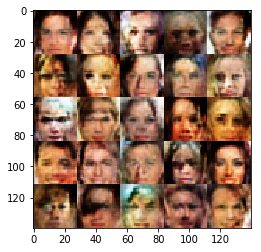

Epoch 1/1... Discriminator Loss: 1.1062... Generator Loss: 5.5235
Epoch 1/1... Discriminator Loss: 1.1244... Generator Loss: 0.9514
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 2.1723
Epoch 1/1... Discriminator Loss: 0.4552... Generator Loss: 2.9284
Epoch 1/1... Discriminator Loss: 0.3899... Generator Loss: 3.8778
Epoch 1/1... Discriminator Loss: 3.3201... Generator Loss: 0.1567
Epoch 1/1... Discriminator Loss: 0.7737... Generator Loss: 3.4357
Epoch 1/1... Discriminator Loss: 0.3805... Generator Loss: 4.7143
Epoch 1/1... Discriminator Loss: 0.4144... Generator Loss: 3.4788
Epoch 1/1... Discriminator Loss: 0.3645... Generator Loss: 4.8553


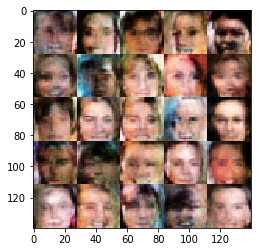

Epoch 1/1... Discriminator Loss: 0.7341... Generator Loss: 7.7264
Epoch 1/1... Discriminator Loss: 0.4351... Generator Loss: 3.4252
Epoch 1/1... Discriminator Loss: 0.7454... Generator Loss: 6.2617
Epoch 1/1... Discriminator Loss: 0.4284... Generator Loss: 4.1360
Epoch 1/1... Discriminator Loss: 0.6834... Generator Loss: 1.7556
Epoch 1/1... Discriminator Loss: 0.6263... Generator Loss: 2.5776
Epoch 1/1... Discriminator Loss: 0.6964... Generator Loss: 1.8673
Epoch 1/1... Discriminator Loss: 0.7567... Generator Loss: 1.3175
Epoch 1/1... Discriminator Loss: 0.5990... Generator Loss: 2.0947
Epoch 1/1... Discriminator Loss: 0.5884... Generator Loss: 2.1442


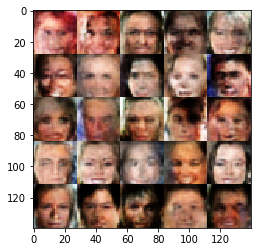

Epoch 1/1... Discriminator Loss: 2.3830... Generator Loss: 0.2456
Epoch 1/1... Discriminator Loss: 1.0785... Generator Loss: 1.0979
Epoch 1/1... Discriminator Loss: 2.8433... Generator Loss: 4.6258
Epoch 1/1... Discriminator Loss: 0.6790... Generator Loss: 2.2912
Epoch 1/1... Discriminator Loss: 0.4197... Generator Loss: 3.9193
Epoch 1/1... Discriminator Loss: 0.5753... Generator Loss: 1.8858
Epoch 1/1... Discriminator Loss: 0.3809... Generator Loss: 4.0804
Epoch 1/1... Discriminator Loss: 0.8312... Generator Loss: 1.4375
Epoch 1/1... Discriminator Loss: 0.3758... Generator Loss: 4.2736
Epoch 1/1... Discriminator Loss: 0.3982... Generator Loss: 5.3456


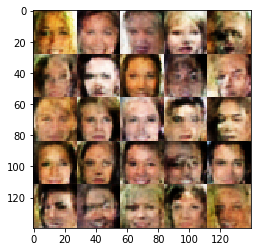

Epoch 1/1... Discriminator Loss: 0.3513... Generator Loss: 5.9247
Epoch 1/1... Discriminator Loss: 0.5248... Generator Loss: 4.1677
Epoch 1/1... Discriminator Loss: 3.1195... Generator Loss: 0.1990
Epoch 1/1... Discriminator Loss: 0.7510... Generator Loss: 1.6443
Epoch 1/1... Discriminator Loss: 0.5080... Generator Loss: 2.6472
Epoch 1/1... Discriminator Loss: 0.6583... Generator Loss: 1.6088
Epoch 1/1... Discriminator Loss: 0.4407... Generator Loss: 3.1305
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 0.5717... Generator Loss: 2.1268
Epoch 1/1... Discriminator Loss: 0.6288... Generator Loss: 1.7165


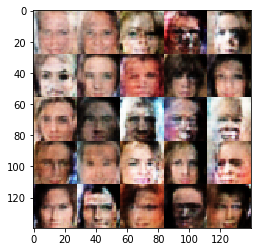

Epoch 1/1... Discriminator Loss: 2.3470... Generator Loss: 0.2995
Epoch 1/1... Discriminator Loss: 0.6564... Generator Loss: 1.6852
Epoch 1/1... Discriminator Loss: 0.4218... Generator Loss: 4.6527
Epoch 1/1... Discriminator Loss: 0.3946... Generator Loss: 4.1330
Epoch 1/1... Discriminator Loss: 0.5497... Generator Loss: 2.2058
Epoch 1/1... Discriminator Loss: 0.4375... Generator Loss: 3.7429
Epoch 1/1... Discriminator Loss: 0.7517... Generator Loss: 2.0121
Epoch 1/1... Discriminator Loss: 0.9310... Generator Loss: 1.3378
Epoch 1/1... Discriminator Loss: 0.4015... Generator Loss: 4.7869
Epoch 1/1... Discriminator Loss: 1.2074... Generator Loss: 2.9401


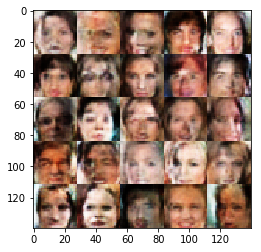

Epoch 1/1... Discriminator Loss: 0.4321... Generator Loss: 3.8413
Epoch 1/1... Discriminator Loss: 0.4564... Generator Loss: 2.7412
Epoch 1/1... Discriminator Loss: 0.4018... Generator Loss: 4.9617
Epoch 1/1... Discriminator Loss: 0.4787... Generator Loss: 2.8993
Epoch 1/1... Discriminator Loss: 0.8241... Generator Loss: 1.3202
Epoch 1/1... Discriminator Loss: 0.7650... Generator Loss: 1.4948
Epoch 1/1... Discriminator Loss: 0.4879... Generator Loss: 2.7472
Epoch 1/1... Discriminator Loss: 3.8114... Generator Loss: 7.3023
Epoch 1/1... Discriminator Loss: 0.3800... Generator Loss: 4.3628
Epoch 1/1... Discriminator Loss: 0.4545... Generator Loss: 2.9733


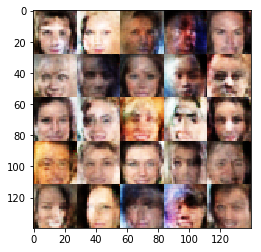

Epoch 1/1... Discriminator Loss: 0.4894... Generator Loss: 3.1381
Epoch 1/1... Discriminator Loss: 1.0524... Generator Loss: 4.8381
Epoch 1/1... Discriminator Loss: 1.0219... Generator Loss: 1.5633
Epoch 1/1... Discriminator Loss: 0.5818... Generator Loss: 1.9601
Epoch 1/1... Discriminator Loss: 0.3753... Generator Loss: 4.0182
Epoch 1/1... Discriminator Loss: 0.6117... Generator Loss: 2.2916
Epoch 1/1... Discriminator Loss: 0.7047... Generator Loss: 1.8733
Epoch 1/1... Discriminator Loss: 1.5627... Generator Loss: 5.2022
Epoch 1/1... Discriminator Loss: 0.4396... Generator Loss: 3.8332
Epoch 1/1... Discriminator Loss: 0.6947... Generator Loss: 1.8468


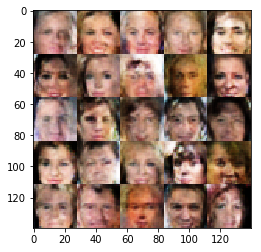

Epoch 1/1... Discriminator Loss: 0.3970... Generator Loss: 3.7590
Epoch 1/1... Discriminator Loss: 0.3672... Generator Loss: 5.2901
Epoch 1/1... Discriminator Loss: 0.6590... Generator Loss: 2.4927
Epoch 1/1... Discriminator Loss: 0.7450... Generator Loss: 1.4782
Epoch 1/1... Discriminator Loss: 0.7450... Generator Loss: 1.4673
Epoch 1/1... Discriminator Loss: 0.5908... Generator Loss: 2.3963
Epoch 1/1... Discriminator Loss: 0.4738... Generator Loss: 3.1084
Epoch 1/1... Discriminator Loss: 1.0774... Generator Loss: 2.9458
Epoch 1/1... Discriminator Loss: 0.8400... Generator Loss: 2.3586
Epoch 1/1... Discriminator Loss: 0.5382... Generator Loss: 2.3554


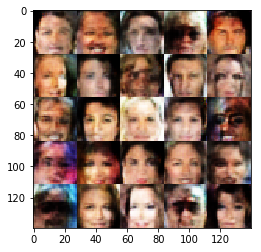

Epoch 1/1... Discriminator Loss: 0.6906... Generator Loss: 1.9668
Epoch 1/1... Discriminator Loss: 0.4308... Generator Loss: 3.0481


KeyboardInterrupt: 

In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.